In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyhacores.utils import *
from pyha import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']

# Application

In [157]:
from pyhacores.fft import R2SDF
from pyhacores.fft.packager import DataWithIndex, Packager, unpackage, package
from scipy.fftpack import fft, fftshift

def make_fft(window):
    A = fft(window, N * 8) / (len(window)/2.0)
    freq = np.linspace(-0.5, 0.5, len(A))
    response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))
    return freq, response

fft_size = 128
input_signal = np.random.uniform(-1, 1, size=(2, fft_size)) + np.random.uniform(-1, 1, size=(2, fft_size)) * 1j
input_signal *= 0.125

## FFT - IFFT loopback

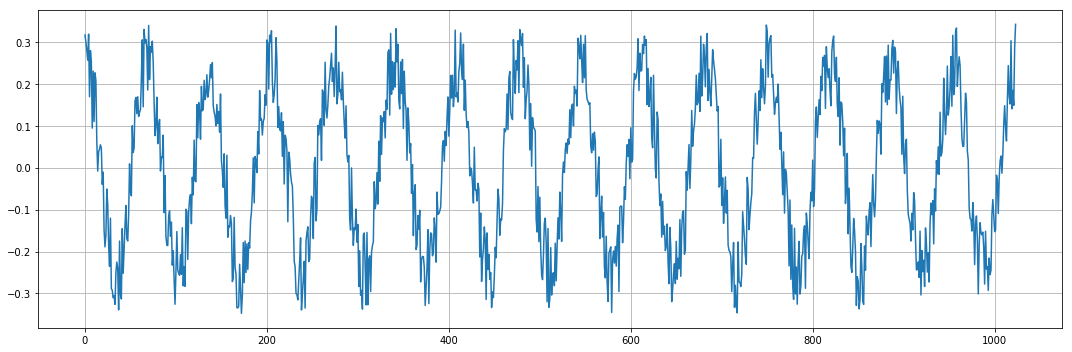

In [221]:
fft_size = 2
samples = 1024
freq = 15
sine = np.exp(2j*np.pi*np.linspace(0, 1, samples)*freq) * 0.25
# input_signal = [1.0 + 1.0j] * 512 # this input signal basically just returns the window taps
noise = np.random.uniform(-1, 1, samples) + np.random.uniform(-1, 1, samples) * 1j
input_signal = sine + noise * 0.1
# N = 256
# input_signal = np.reshape(input_signal, (-1, N))
plt.plot(input_signal)
show_plot()

In [222]:
dut = R2SDF(fft_size, twiddle_bits=18)
fft_sims = simulate(dut, input_signal, output_callback=unpackage, input_callback=package, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 1029/1029 [00:00<00:00, 2847.50it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [223]:
snr(np.array(fft_sims['MODEL']), fft_sims['PYHA'])

91.7104794765119

(1024,)
(511, 2)
511
1022


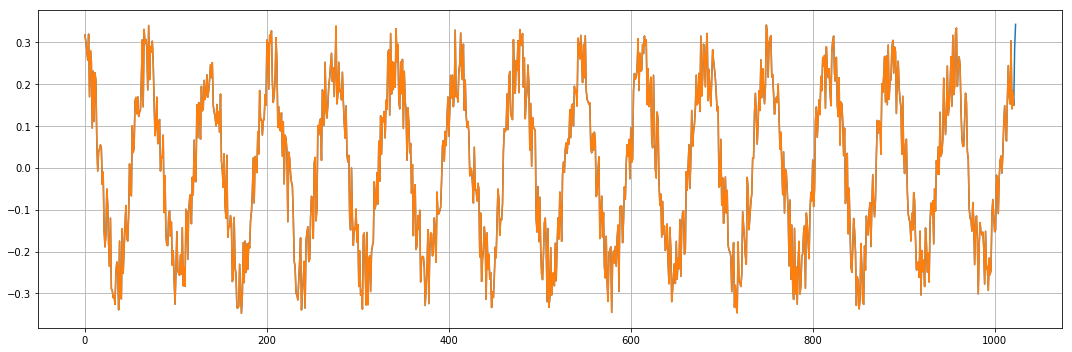

In [234]:
print(input_signal.shape)
rev_input = np.resize(input_signal, (-1, fft_size))
print(rev_input.shape)
print(len(rev_input))
print(len(rev_input.flatten()))
for i, _ in enumerate(rev_input):
    rev_input[i] = toggle_bit_reverse(rev_input[i], fft_size)
rev_input = rev_input.flatten()
plt.plot(input_signal)
plt.plot(rev_input)
show_plot()

In [225]:
dut = R2SDF(fft_size, twiddle_bits=18, input_ordering='bitreversed')
fft_sims = simulate(dut, rev_input, output_callback=unpackage, input_callback=package, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 1027/1027 [00:00<00:00, 2792.14it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [226]:
snr(np.array(fft_sims['MODEL']), fft_sims['PYHA'])

91.69858279942426

In [196]:
dut = R2SDF(fft_size, twiddle_bits=18, inverse=True)
sims = simulate(dut, np.array(fft_sims['PYHA']).flatten(), output_callback=unpackage, input_callback=package, simulations=simulations)


INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 1029/1029 [00:00<00:00, 2923.06it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [197]:
snr(np.array(sims['MODEL']), sims['PYHA'])

-0.6112972156965196

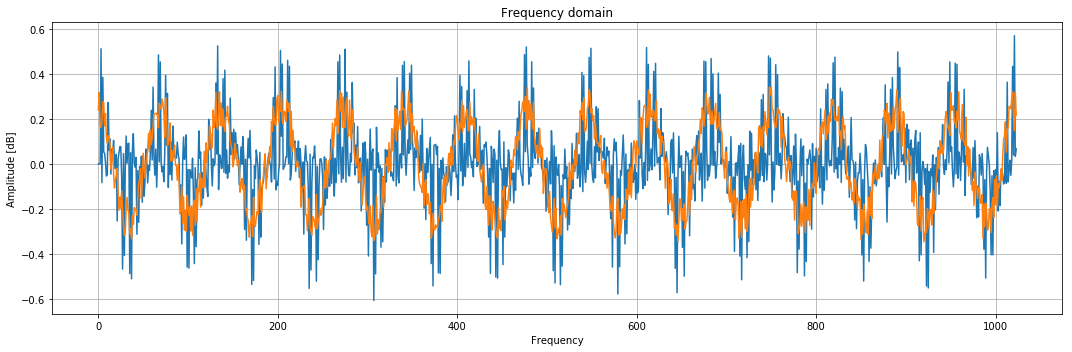

In [198]:
plt.title('Frequency domain')
# for key, value in sims.items():
# plt.plot(np.array(sims['MODEL']).flatten())
plt.plot(np.array(sims['PYHA']).flatten())
plt.plot(input_signal)

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
# plt.ylim([-120, 1])
show_plot()

## Hanning

In [7]:
dut = Windower(N, window='hanning', coefficient_bits=9)
sims = simulate(dut, input_signal, output_callback=unpackage, input_callback=package, simulations=simulations)

NameError: name 'Windower' is not defined

In [ ]:
plt.title('Frequency domain')
for key, value in sims.items():
    plt.plot(*make_fft(value[0]))

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
plt.ylim([-120, 1])
show_plot()

## Hamming

In [ ]:
dut = Windower(N, window='hamming', coefficient_bits=9)
sims = simulate(dut, input_signal, output_callback=unpackage, input_callback=package, simulations=simulations)

In [ ]:
plt.title('Frequency domain')
for key, value in sims.items():
    plt.plot(*make_fft(value[0]))

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
plt.ylim([-120, 1])
show_plot()

# Limitations

## Fixed-point
Expects standard FPGA Fixed point format i.e 18 bits (incl. sign) and scaled to -1...1 range.

In [ ]:
print(f'Minimum number representabe: {2**-17}')

## Coefficients are stored in LUTs (as constants)
Storing 18bit coefficnets for large FFT can take huge amounts of LUTS. I recommend using bitwidth of ~8, then synthsis tool can compress most of them.

## FFT outputs are bitreversed, IFFT inputs expected to be bitreversed

## Scaling is different from numpy
Numpy does not scale the FFT and scales IFFT with 1/n. This core works in oppsite way i.e. FFT is scaled with 1/n and IFFT has no scaling.

# Synthesis
Resource usage depends heavily on filter taps. For example, 64 tap halfband filter needs only 16 multipliers (18bit). Complex signal needs 2 filters, so in total we could expect 32 multipliers (18bit).

In [ ]:
# NBVAL_IGNORE_OUTPUT
c = convertToVHDL(dut, '/tmp/pyha_output')
_ = c.make_quartus_netlist()

In [ ]:
print(f'Logic elements: {c.last_logic_elements}')
print(f'Memory: {c.last_memory_bits}')
print(f'Multipler (18bit): {c.last_multiplier//2}')